# ERA5 Analysis (Further Practice)

## 20/10/25

This notebook serves as further practice in the manipulation and analysis of ERA5 data files. The notebook is seperated into 3 sections:

1. Maps
    - Making a map of the UK for 2m temperature for 2022 and comparing to the same map averaged over all available years
1. Linear Plots
    - Adjusting the uncertainties in a linear plot with the goal of the uncertainty on the slope being driven by the variability of the data, not the uncertainty on each data point
    - Creating and comparing plots of:
        1. The 4 seasons
        1. Northern and Southern UK
1. Histograms
    - Creating and comparing plots for 2m temperature in Winter for all years before 1990 and all years after (and including) 1990

All sections make use of the same simple file with the following attributes:
- ERA5-Land monthly averaged data from 1950 to present
- Product type: Monthly averaged reanalysis
- Variable: 2m temperature
- Years: All available (1950-2025)
- Months: All months (2025 data only reaches September)
- Time: 00:00 (Not relevent as monthly averaged reanalysis)
- Geographical area: North: 61°, West: -8°, South: 49°, East: 2°
- Data format: NetCDF4
- Size: 10.02MB


## 1. Maps

In this section the goal is as follows:
- Make two maps of the UK for one variable (2m temperature)
    1. Just for 1 year (2022) averaged over all months
    1. Averaged over all years
- Compare the two maps
- Seperate the data into summer and winter seasons and compare

### 1.1. Maps for all seasons

The first step was to import the relevant modules and dataset:

In [117]:
# Importing modules
import xarray as xr
import regionmask
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Specifying file path
file_path = r"C:\Users\itsna\OneDrive\Desktop\MSc Work\DataSets\2m_temp_uk_allyears.nc"

# Loading the dataset
ds = xr.open_dataset(file_path)

I then created a map for 2m temperature over all years:

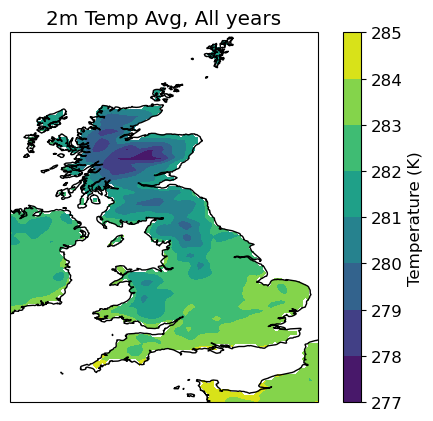

<Figure size 640x480 with 0 Axes>

In [118]:
# Loading the longitudinal and latitudinal values from the dataset
long = ds.variables['longitude'][:] # [:] takes full slice of the data, potentially equivelent to using .values?
lat = ds.variables['latitude'][:]

# Loading the 2m temperature values from the dataset
temp_values = ds.t2m.values

# Averaging the temperature values
temp_avg = np.mean(temp_values, axis=0) # axis=0 returns the mean of each column as an array

# Making a new GeoAxes with lat/lon projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Setting the plotted area
ax.set_extent([-8, 2, 49, 61])

# Setting the axes title
ax.set_title('2m Temp Avg, All years')

# Setting the resolution and colour of the coastlines
ax.coastlines(resolution='10m', color='black')

# Drawing the (filled) contour bands
contour = plt.contourf(long, lat, temp_avg, transform=ccrs.PlateCarree(), cmap="viridis")

# Setting the colour bar orientation and label
cbar = plt.colorbar(contour, orientation="vertical")
cbar.set_label(u"Temperature (K)")

# Showing the plot
plt.figure()
plt.show()

Next I created a plot for just 2022, averaged over all months. To do this I selected a section of time (covering 2022) when loading the data values. The rest of the code remained the same:

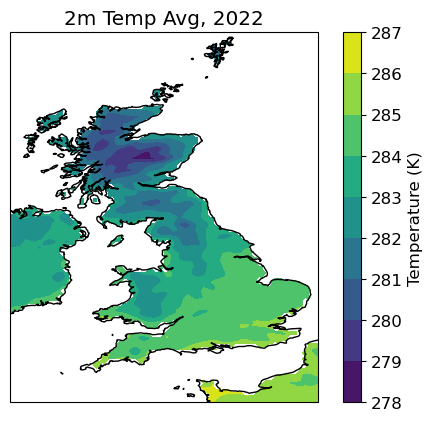

<Figure size 640x480 with 0 Axes>

In [119]:
# Loading the longitudinal and latitudinal values from the dataset
long = ds.variables['longitude'][:] # [:] takes full slice of the data, potentially equivelent to using .values?
lat = ds.variables['latitude'][:]

# Loading the 2m temperature values from the dataset
temp_values_2022 = ds['t2m'].sel(valid_time=slice("2022-01-01", "2022-12-31"))

# Averaging the temperature values
temp_avg = np.mean(temp_values_2022, axis=0) # axis=0 returns the mean of each column as an array

# Making a new GeoAxes with lat/lon projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Setting the plotted area
ax.set_extent([-8, 2, 49, 61])

# Setting the axes title
ax.set_title('2m Temp Avg, 2022')

# Setting the resolution and colour of the coastlines
ax.coastlines(resolution='10m', color='black')

# Drawing the (filled) contour bands
contour = plt.contourf(long, lat, temp_avg, transform=ccrs.PlateCarree(), cmap="viridis")

# Setting the colour bar orientation and label
cbar = plt.colorbar(contour, orientation="vertical")
cbar.set_label(u"Temperature (K)")

# Showing the plot
plt.figure()
plt.show()

To make the plots easier to compare I then combined the code to plot both plots side-by-side. I also converted the temperature values from Kelvin to Celsius to make the data easier to follow:

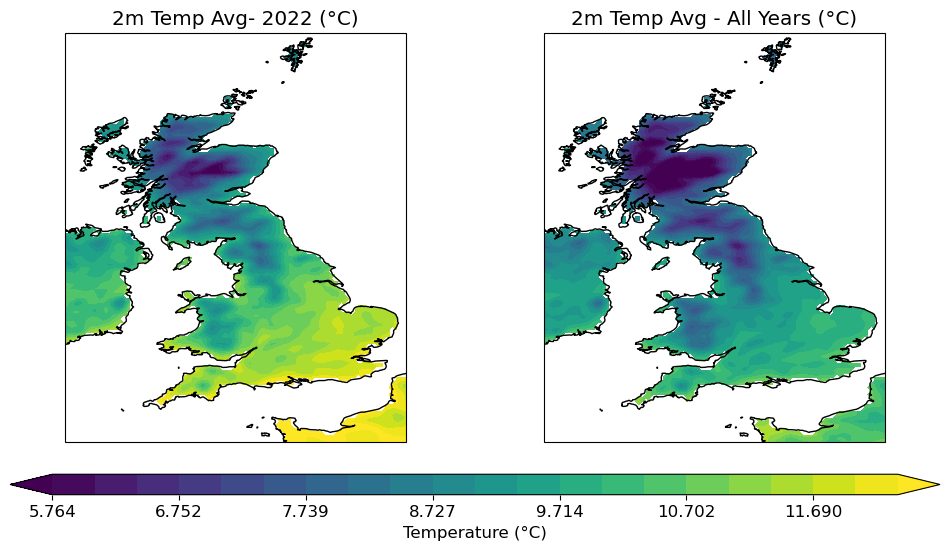

In [145]:
# Choosing colourmap ('viridis', 'plasma', 'coolwarm' and 'Spectral_r' are good examples)
colour_map = "viridis"

# Converting from kelvin to celsius
t2m_all_C = t2m_all - 273.15
t2m_2022_C = t2m_2022 - 273.15

# Computing shared color levels (based on Celsius values)
# .ravel() flattens 2D data to 1D to make it easier to compute percentiles over all the grid cells
# np.concatenate() stacks flattened arrays so can compute one set of limits that works for both panels
# np.nanpercentile(..., 2) and np.nanpercentile(..., 98) take the 2nd and 98th percentile to eliminate outliers
vmin = np.nanpercentile(np.concatenate([t2m_all_C.ravel(), t2m_2022_C.ravel()]), 2)
vmax = np.nanpercentile(np.concatenate([t2m_all_C.ravel(), t2m_2022_C.ravel()]), 98)
levels = np.linspace(vmin, vmax, 21)

# Creating figure and layout using GridSpec
fig = plt.figure(figsize=(12, 6), constrained_layout=False)
gs = fig.add_gridspec(nrows=2, ncols=2, height_ratios=[20, 1], hspace=0.15, wspace=0.06)

# Creating top row (the two maps)
ax0 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())  # 2022 mean
ax1 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())  # all-years mean

# Creating bottom row (shared colour bar)
cax = fig.add_subplot(gs[1, :])

# Map settings (No gridlines)
for ax in (ax0, ax1):
    ax.set_extent([-8, 2, 49, 61])
    ax.coastlines(resolution='10m', color='black')

# Settings for left panel (2022)
cs0 = ax0.contourf(
    lon, lat, t2m_2022_C,
    levels=levels, cmap=colour_map,
    transform=ccrs.PlateCarree(), extend='both'
)
ax0.set_title("2m Temp Avg- 2022 (°C)")

# Settings for right panel (all years)
cs1 = ax1.contourf(
    lon, lat, t2m_all_C,
    levels=levels, cmap=colour_map,
    transform=ccrs.PlateCarree(), extend='both'
)
ax1.set_title("2m Temp Avg - All Years (°C)")

# Shared colorbar
cb = fig.colorbar(cs1, cax=cax, orientation="horizontal")
cb.set_label("Temperature (°C)")

plt.show()


When plotted side-by-side with a shared colourbar, the temperature difference between 2022 and the annual average becomes clear. Below I print the mean temperature over the whole area both in 2022 and over all years:

In [121]:

TempAll=np.nanmean(t2m_all_C)
Temp2022=np.nanmean(t2m_2022_C)
print(f"Avg temp (All years): {TempAll:.1f}°C \nAvg temp (2022): {Temp2022:.1f}°C \nThat's a difference of {abs(TempAll - Temp2022):.1f}°C")


Avg temp (All years): 8.8°C 
Avg temp (2022): 10.1°C 
That's a difference of 1.3°C


### 1.2. Maps for Summer and Winter

I then moved on to creating maps for Summer and Winter instead of all four seasons, the idea being to create a better picture of the record breaking 2022 UK summer. I chose the summer season to be June, July, August (JJA) and the winter season to be December, January, Febuary (DJF).

Below I create plots covering the summer season only:

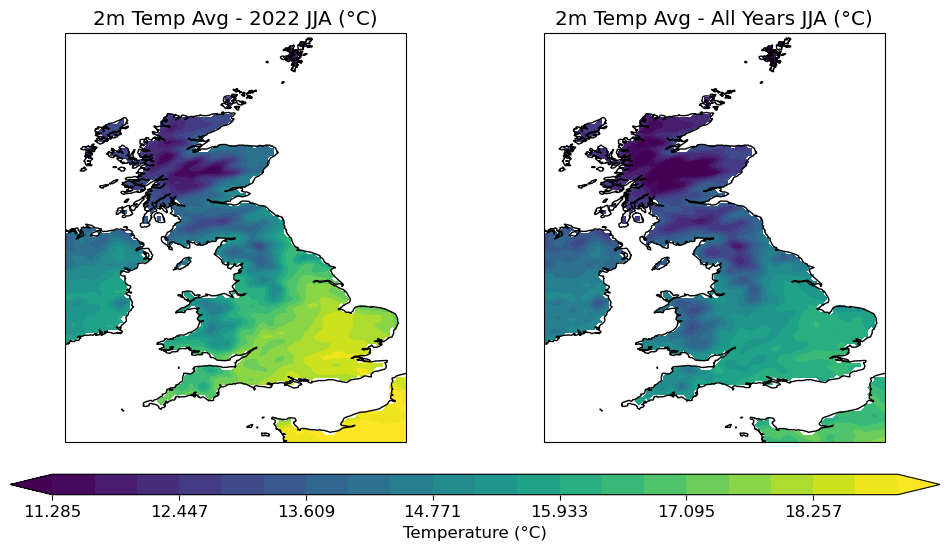

In [146]:
# Choosing colourmap ('viridis', 'plasma', 'coolwarm' and 'Spectral_r' are good examples)
colour_map = "viridis"

# Summer selection and averaging
# All-years JJA mean (June, July, August over all years)
t2m_all_JJA  = ds['t2m'].where(ds['valid_time'].dt.month.isin([6, 7, 8]), drop=True).mean('valid_time')

# 2022 JJA mean (June, July, August 2022 only)
t2m_2022_JJA = ds['t2m'].sel(valid_time=slice("2022-06-01", "2022-08-31")).mean('valid_time')

# Converting from kelvin to celsius
t2m_all_C  = (t2m_all_JJA  - 273.15).values
t2m_2022_C = (t2m_2022_JJA - 273.15).values

# Computing shared color levels (based on Celsius values)
# .ravel() flattens 2D data to 1D to make it easier to compute percentiles over all the grid cells
# np.concatenate() stacks flattened arrays so can compute one set of limits that works for both panels
# np.nanpercentile(..., 2) and np.nanpercentile(..., 98) take the 2nd and 98th percentile to eliminate outliers
vmin = np.nanpercentile(np.concatenate([t2m_all_C.ravel(), t2m_2022_C.ravel()]), 2)
vmax = np.nanpercentile(np.concatenate([t2m_all_C.ravel(), t2m_2022_C.ravel()]), 98)
levels = np.linspace(vmin, vmax, 21) # Creates 21 evenly spaced level values from vmin to vmax

# Creating figure and layout using GridSpec
fig = plt.figure(figsize=(12, 6), constrained_layout=False)
gs = fig.add_gridspec(nrows=2, ncols=2, height_ratios=[20, 1], hspace=0.15, wspace=0.06)

# Creating top row (the two maps)
ax0 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())  # 2022 JJA mean
ax1 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())  # all-years JJA mean

# Creating bottom row (shared colour bar)
cax = fig.add_subplot(gs[1, :])

# Map settings (No gridlines)
for ax in (ax0, ax1):
    ax.set_extent([-8, 2, 49, 61])
    ax.coastlines(resolution='10m', color='black')

# Settings for left panel (2022 JJA)
cs0 = ax0.contourf(
    lon, lat, t2m_2022_C,
    levels=levels, cmap=colour_map,
    transform=ccrs.PlateCarree(), extend='both'
)
ax0.set_title("2m Temp Avg - 2022 JJA (°C)")

# Settings for right panel (all-years JJA)
cs1 = ax1.contourf(
    lon, lat, t2m_all_C,
    levels=levels, cmap=colour_map,
    transform=ccrs.PlateCarree(), extend='both'
)
ax1.set_title("2m Temp Avg - All Years JJA (°C)")

# Shared colorbar
cb = fig.colorbar(cs1, cax=cax, orientation="horizontal")
cb.set_label("Temperature (°C)")

plt.show()


I then went on to create plots for the winter season also. For the 2022 winter season I used December 2021, January 2022 and Febuary 2022. To make the plots easier to compare I created four subplots with a shared colour-bar and used the colour map "Spectral_r" to create more seperation between hot and cold values and make the data appear more intuitively temperature related:

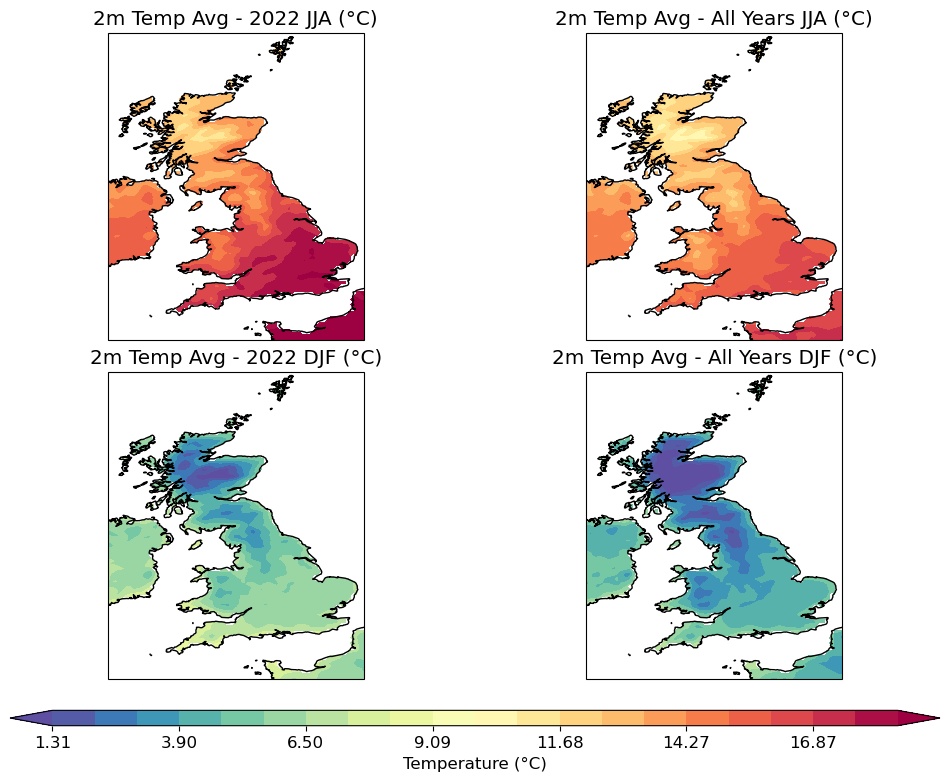

In [147]:
# Choosing colourmap ('viridis', 'plasma', 'coolwarm' and 'Spectral_r' are good examples)
colour_map = "Spectral_r"

# Creating the means for each season

# Summer (all years)
t2m_all_JJA  = ds['t2m'].where(ds['valid_time'].dt.month.isin([6, 7, 8]), drop=True).mean('valid_time')

# Summer (2022)
t2m_2022_JJA = ds['t2m'].sel(valid_time=slice("2022-06-01", "2022-08-31")).mean('valid_time')

# Winter (all years) (pool all Dec/Jan/Feb across the record)
t2m_all_DJF  = ds['t2m'].where(ds['valid_time'].dt.month.isin([12, 1, 2]), drop=True).mean('valid_time')

# Winter (2022) (Dec 2021 + Jan 2022 + Feb 2022)
t2m_2022_DJF = ds['t2m'].sel(valid_time=slice("2021-12-01", "2022-02-28")).mean('valid_time')

# Converting from kelvin to celsius
t2m_2022_JJA_C = (t2m_2022_JJA - 273.15).values
t2m_all_JJA_C  = (t2m_all_JJA  - 273.15).values
t2m_2022_DJF_C = (t2m_2022_DJF - 273.15).values
t2m_all_DJF_C  = (t2m_all_DJF  - 273.15).values

# Creating shared colour values
# .ravel() flattens 2D data to 1D to make it easier to compute percentiles over all the grid cells
# np.concatenate() stacks flattened arrays so can compute one set of limits that works for both panels
# np.nanpercentile(..., 2) and np.nanpercentile(..., 98) take the 2nd and 98th percentile to eliminate outliers
stack = np.concatenate([t2m_2022_JJA_C.ravel(), t2m_all_JJA_C.ravel(), t2m_2022_DJF_C.ravel(), t2m_all_DJF_C.ravel()])
vmin = np.nanpercentile(stack, 2)
vmax = np.nanpercentile(stack, 98)
levels = np.linspace(vmin, vmax, 21)

# Creating figure and layout using GridSpec
fig = plt.figure(figsize=(12, 9), constrained_layout=False)
gs = fig.add_gridspec(nrows=3, ncols=2, height_ratios=[20, 20, 1], hspace=0.15, wspace=0.06)

# Top row (Summer)
ax0 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())  # 2022 JJA
ax1 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())  # All-years JJA

# Middle row (Winter)
ax2 = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())  # 2022 DJF
ax3 = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())  # All-years DJF

# Bottom row (colour-bar)
cax = fig.add_subplot(gs[2, :])

# Settings for the maps (no gridlines)
for ax in (ax0, ax1, ax2, ax3):
    ax.set_extent([-8, 2, 49, 61])
    ax.coastlines(resolution='10m', color='black')

# Plotting each panel
cs0 = ax0.contourf(lon, lat, t2m_2022_JJA_C, levels=levels, cmap=colour_map,
                   transform=ccrs.PlateCarree(), extend='both')
ax0.set_title("2m Temp Avg - 2022 JJA (°C)")

cs1 = ax1.contourf(lon, lat, t2m_all_JJA_C, levels=levels, cmap=colour_map,
                   transform=ccrs.PlateCarree(), extend='both')
ax1.set_title("2m Temp Avg - All Years JJA (°C)")

cs2 = ax2.contourf(lon, lat, t2m_2022_DJF_C, levels=levels, cmap=colour_map,
                   transform=ccrs.PlateCarree(), extend='both')
ax2.set_title("2m Temp Avg - 2022 DJF (°C)")

cs3 = ax3.contourf(lon, lat, t2m_all_DJF_C, levels=levels, cmap=colour_map,
                   transform=ccrs.PlateCarree(), extend='both')
ax3.set_title("2m Temp Avg - All Years DJF (°C)")

# Choosing the colour-bar settings
cb = fig.colorbar(cs3, cax=cax, orientation="horizontal")
cb.set_label("Temperature (°C)")

plt.show()


Plotting the maps this way highlights not only the large disparity between the 2022 summer and an average summer, but also how even the 2022 winter was warmer than average.

## 2. Linear plots

In this section the aims are as follows:
- Adjust the uncertainties in a linear plot with the goal of the uncertainty on the slope being driven by the variability of the data, not the uncertainty on each data point
- Create and compare plots of:
    1. The 4 seasons
    1. Northern and Southern UK

### 2.1. Residual Driven Uncertainties

In this part I adjust the linear plot code to ensure that the uncertainty on the slope is driven by the residuals, not the individual data-point uncertainties. To do tis I simply removed the 'sigma' input from the 'curve_fit' line of code. This removes the data-point uncertanties.

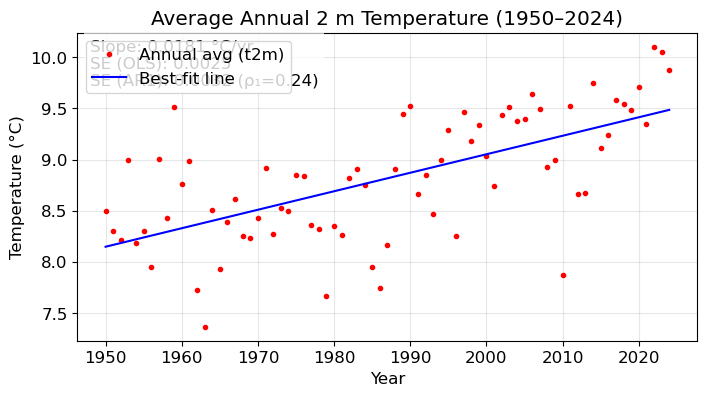

In [148]:
# Importing relevant modules
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

# Defining function for linear fit
def linear_model(x, m, b):
    return m * x + b

# Ignoring nan values
mask = np.isfinite(x) & np.isfinite(y) 
# np.isfinite() returns boolean array (false for nan values, true for real)
# mask only true where x and y both real and finite
x_fit = x[mask]
y_fit = y[mask]

# Unweighted fit with uncertainties from residuals (sigma removed)
popt, pcov = curve_fit(linear_model, x_fit, y_fit)
m, b = popt
m_err = np.sqrt(pcov[0, 0])

# Plotting + annotating
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(x, y, '.', color='red', label='Annual avg (t2m)')
ax.plot(x_fit, linear_model(x_fit, m, b), 'b-', label='Best-fit line')
ax.set_xlabel('Year'); ax.set_ylabel('Temperature (°C)')
ax.set_title(f'Average Annual 2 m Temperature ({int(x.min())}–{int(x.max())})')
ax.grid(True, alpha=0.3); ax.legend()

ax.text(0.02, 0.98,
        f"Slope: {m:.4f} °C/yr\nSE (OLS): {m_err:.4f}\nSE (AR1): {m_err_corr:.4f} (ρ₁={rho1:.2f})",
        transform=ax.transAxes, va='top', ha='left',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
plt.show()




### 2.2. The four seasons

I then extended the code to plot all four seasons, this way we can compare the slopes of each. We can see from these plots that the slopes are similar for every season, with winter being the steepest.

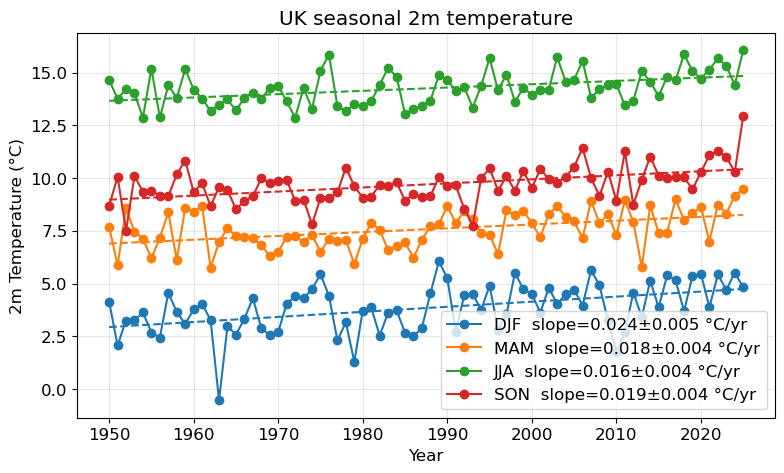

In [141]:
# Importing relevant modules
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  # only used to decode timestamps

# Defining linear function
def linear_model(x, m, b):
    return m * x + b

# Monthly UK average temp (kelvin) as a 1D array aligned with time
t = pd.to_datetime(ds['valid_time'].values)
monthly_K = np.nanmean(ds['t2m'].values, axis=(1, 2))
monthly_C = monthly_K - 273.15 # Converting to celcius

# Making season / season_year arrays (Dec goes into following years winter season)
month = t.month.values
year  = t.year.values

def season_label(m):
    if m in (12, 1, 2):  return 'DJF' # Winter (Dec, Jan, Feb)
    if m in (3, 4, 5):   return 'MAM' # Spring (Mar, Apr, May)
    if m in (6, 7, 8):   return 'JJA' # Summer (Jun, Jul, Aug)
    return 'SON' # Autumn (Sep, Oct, Nov)

season = np.array([season_label(m) for m in month])
season_year = year.copy()
season_year[month == 12] = season_year[month == 12] + 1  # Dec counts toward next winter

# Averagnig the 3 months per season-year for each season and fitting a line
def season_series_vals(season_name):
    mask = (season == season_name)
    years_s = season_year[mask]
    vals_s  = monthly_C[mask]
    # Aggregating by season_year using a loop
    years_unique = np.unique(years_s)
    y_vals = []
    for yy in years_unique:
        y_vals.append(np.nanmean(vals_s[years_s == yy]))  # mean of the 3 months
    y_vals = np.asarray(y_vals, dtype=float)
    x_years = years_unique.astype(float)
    return x_years, y_vals

def fit_simple(x, y):
    # Guard against NaNs
    ok = np.isfinite(x) & np.isfinite(y)
    x_fit = x[ok]; y_fit = y[ok]
    popt, pcov = curve_fit(linear_model, x_fit, y_fit)  # unweighted (unc driven by residuals)
    m, b = popt
    m_err = float(np.sqrt(pcov[0, 0]))
    return m, b, m_err, x_fit, y_fit

# Building and fitting for all four seasons
x_djf, y_djf = season_series_vals('DJF'); m_djf, b_djf, se_djf, xd, yd = fit_simple(x_djf, y_djf)
x_mam, y_mam = season_series_vals('MAM'); m_mam, b_mam, se_mam, xm, ym = fit_simple(x_mam, y_mam)
x_jja, y_jja = season_series_vals('JJA'); m_jja, b_jja, se_jja, xj, yj = fit_simple(x_jja, y_jja)
x_son, y_son = season_series_vals('SON'); m_son, b_son, se_son, xs, ys = fit_simple(x_son, y_son)

# Plotting all four on one figure
fig, ax = plt.subplots(figsize=(9, 5))

ln_d, = ax.plot(x_djf, y_djf, 'o-', label=f"DJF  slope={m_djf:.3f}±{se_djf:.3f} °C/yr")
ax.plot(x_djf, linear_model(x_djf, m_djf, b_djf), '--', color=ln_d.get_color())

ln_m, = ax.plot(x_mam, y_mam, 'o-', label=f"MAM  slope={m_mam:.3f}±{se_mam:.3f} °C/yr")
ax.plot(x_mam, linear_model(x_mam, m_mam, b_mam), '--', color=ln_m.get_color())

ln_j, = ax.plot(x_jja, y_jja, 'o-', label=f"JJA  slope={m_jja:.3f}±{se_jja:.3f} °C/yr")
ax.plot(x_jja, linear_model(x_jja, m_jja, b_jja), '--', color=ln_j.get_color())

ln_s, = ax.plot(x_son, y_son, 'o-', label=f"SON  slope={m_son:.3f}±{se_son:.3f} °C/yr")
ax.plot(x_son, linear_model(x_son, m_son, b_son), '--', color=ln_s.get_color())

ax.set_xlabel('Year')
ax.set_ylabel('2m Temperature (°C)')
ax.set_title('UK seasonal 2m temperature')
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()


### 2.3. Northern/Southern UK

I then created linear plots for the North and South of the UK to see how they compare. I arbitrarily decided on the latitude 53°N to be the boundary between North and South. Once again, there is no significant difference between the two.

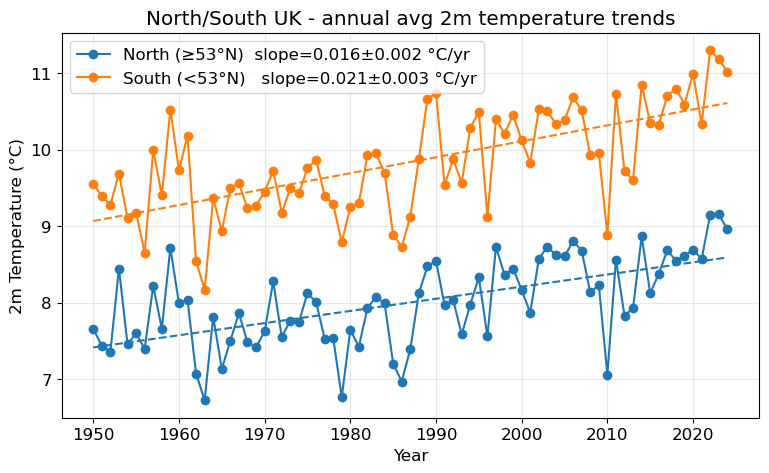

In [150]:
# Importing relevant modules
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Deciding North/South boundary (Chose North >= 53°N and South < 53°N)
SPLIT_LAT = 53.0

# Def linear model
def linear_model(x, m, b):
    return m * x + b

# Extracting arrays
time_index = pd.to_datetime(ds['valid_time'].values)

lat = ds['latitude'].values
t2m = ds['t2m'].values

# Making North/South masks from the latitude defined earlier
north_mask = lat >= SPLIT_LAT
south_mask = lat <  SPLIT_LAT

# Monthly spatial avgs in kelvin
north_monthly_K = np.nanmean(t2m[:, north_mask, :], axis=(1, 2))
south_monthly_K = np.nanmean(t2m[:, south_mask, :], axis=(1, 2))

# Converting to °C
north_monthly = north_monthly_K - 273.15
south_monthly = south_monthly_K - 273.15

# Annual avgs
n_months = len(time_index)
n_years  = n_months // 12
# Trimming any incomplete years (just 2025 in this case)
north_trim = north_monthly[:n_years*12].reshape(n_years, 12).mean(axis=1)
south_trim = south_monthly[:n_years*12].reshape(n_years, 12).mean(axis=1)

# Creating x-axis of years starting with the first month in the dataset (1950)
y0 = int(time_index[0].year)
years = np.arange(y0, y0 + n_years).astype(float)

# Fitting lines (no sigma so uncertainties driven by residuals)
def fit_series(x, y):
    mask = np.isfinite(x) & np.isfinite(y)
    x_fit, y_fit = x[mask], y[mask]
    popt, pcov = curve_fit(linear_model, x_fit, y_fit)  # no sigma
    m, b = popt
    m_se = float(np.sqrt(pcov[0, 0]))
    return m, b, m_se, x_fit, y_fit

# Running linear fits for North/South seperately
mN, bN, seN, xN, yN = fit_series(years, north_trim)
mS, bS, seS, xS, yS = fit_series(years, south_trim)

# Plotting
fig, ax = plt.subplots(figsize=(9, 5))

lnN, = ax.plot(xN, yN, 'o-', label=f"North (≥{SPLIT_LAT:.0f}°N)  slope={mN:.3f}±{seN:.3f} °C/yr")
ax.plot(xN, linear_model(xN, mN, bN), '--', color=lnN.get_color())

lnS, = ax.plot(xS, yS, 'o-', label=f"South (<{SPLIT_LAT:.0f}°N)   slope={mS:.3f}±{seS:.3f} °C/yr")
ax.plot(xS, linear_model(xS, mS, bS), '--', color=lnS.get_color())

ax.set_xlabel('Year')
ax.set_ylabel('2m Temperature (°C)')
ax.set_title('North/South UK - annual avg 2m temperature trends')
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()
